# FDMT Boxcar High DM problem

In the beginning FREDDA worked. Or did it? 

FREDDA was meant to average over time samples before doing the FDMT. This was its way of handling beyond-the-diagonal DMs. This is nice because it's more 'matched filter-y' - it sums over different widths in time for the top and bottom of the band, which is exactly what an impulsive FRB should do.

All was well in the land.

Then Clancy spoke up and said that it was nonsense to boxcar with a (well a boxcar shape) if we're already done some time averaging already. Which is an excellent point.

But we were finding FRBs anyway.

Then Keith fixed something and all hell broke loose.

It turned out FREDDA wsn't working as advertised. It was pretending to average over time, but actually it was just copying the current sample and saying it had averaged over the last N. As it turns out, this is a rather nice mistake to make, because you can still catch the smeared FRBs in the boxcar. But you miss out on the fancy "difference widths over the band" feature.

So Keith fixed it, and then now we get lots of high DM candidates, because FREDDA doesn't weight the outputs correctly. Clancy was right all along.

In this notebook we'll demonstrate the problem. I  can't think straight enough or long enough to know how to fix it.

In [2]:
import numpy as np
from pylab import *
import fdmt
import boxcar
%matplotlib inline


In [23]:
nf = 336 # number of channels - must be a power of 2 currently.
fmax = 1448. +0.5#  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 256 # Number of samples per block
tsamp = 1.0 # milliseconds
reload(fdmt)
thefdmt = fdmt.Fdmt(fmin, df, nf, nd, nt) # make FDMT
theoverlap = fdmt.OverlapAndSum(nd, nt) # Make overlap and sum operator
for i, s in enumerate(thefdmt.hist_state_shape):
    print 'Iteration', i, 'shape=', s, 'total elements=', s.prod()


Iteration 0 shape= [336   6 262] total elements= 528192
Iteration 1 shape= [168  10 266] total elements= 446880
Iteration 2 shape= [ 84  19 275] total elements= 438900
Iteration 3 shape= [ 42  37 293] total elements= 455322
Iteration 4 shape= [ 21  72 328] total elements= 495936
Iteration 5 shape= [ 11 139 395] total elements= 603955
Iteration 6 shape= [  6 266 522] total elements= 833112
Iteration 7 shape= [  3 490 746] total elements= 1096620
Iteration 8 shape= [   2  847 1103] total elements= 1868482
Iteration 9 shape= [   1 1024 1280] total elements= 1310720


# Does it work?
Here's some code to show that it works, more or less

(336, 256) 335.86055535362874


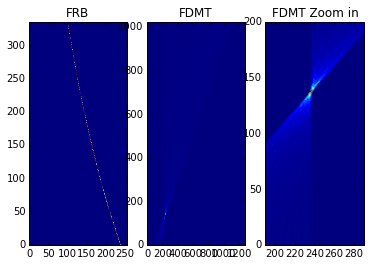

In [24]:


# Here's the FDMT of an FRB with low DM
import simfrb # in same directory as fdmt
reload(simfrb)

# I haven't had time to tidy this up - the untis are funny and the FRB is updside down and transposed
# With respect to what the FDMT wants to see - just trust me OK.
# Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=100, ntimes=nt, offset=100).T
frb = np.flipud(frb)
print frb.shape, frb.sum()
fdmtfrb = thefdmt(frb)
fig, axs = subplots(1,3)
axs[0].imshow(frb, aspect='auto', origin='lower')
axs[0].set_title('FRB')
axs[1].imshow(fdmtfrb, aspect='auto', origin='lower')
axs[1].set_title("FDMT")
axs[2].imshow(fdmtfrb, aspect='auto', origin='lower')
axs[2].set_xlim(240-50, 240+50)
axs[2].set_ylim(0,200)
axs[2].set_title('FDMT Zoom in')





This is nice, but if you have nd>nt, then you can't correctly detect FRBs with DMs lager than nt so you need to "overlap and sum". Here's an example of how that works.

(336, 1024)


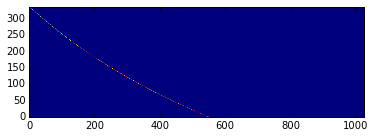

In [25]:
# First make a really long FRB. We'll chop it itto blocks later.
longfrb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=100*4, ntimes=nt*4, offset=0).T
longfrb = np.flipud(longfrb)

print longfrb.shape

imshow(longfrb, origin='lower')

In [26]:
def plot_fdmt_osum(thefdmt, longfrb, osum_vmax=None):

    # Next, we'll block it up in the way the FDMT does it
    nsamples = longfrb.shape[1]
    nblocks = nsamples/nt

    
    fig, axs = subplots(3,nblocks, figsize=(18,12))
    theoverlap = fdmt.OverlapAndSum(nd, nt) # Make overlap and sum operator
    plotdm = slice(0, 200) # Only plot the interesting DMs
    frbsum = longfrb.sum()
    
    outblocks = []

    for blk in xrange(nblocks):
        din = longfrb[:, blk*nt:(blk+1)*nt] # chop out this block the the fdmt
        fout = thefdmt(din)
        overlap_out = theoverlap(fout).copy() # need to add copy otherwise matplotlib deeply confused.
        #print overlap_out.min(), overlap_out.max(), frbsum, blk
        
        outblocks.append(overlap_out)

        axs[0, blk].imshow(din, aspect='auto', origin='lower')
        axs[1, blk].imshow(fout, aspect='auto', origin='lower')
        axs[2, blk].imshow(overlap_out, aspect='auto', origin='lower', vmax=osum_vmax)

        axs[2, blk].set_xlabel('Time (samples)')

        axs[0, blk].set_title('Block {}'.format(blk))

        if blk == 0:
            axs[0, blk].set_ylabel('Input. (channel)')
            axs[1, blk].set_ylabel('FDMT output (idt)')
            axs[2, blk].set_ylabel('Overlap output (idt)')
            
    return np.array(outblocks)


356.3116607604681 668.2724659835752


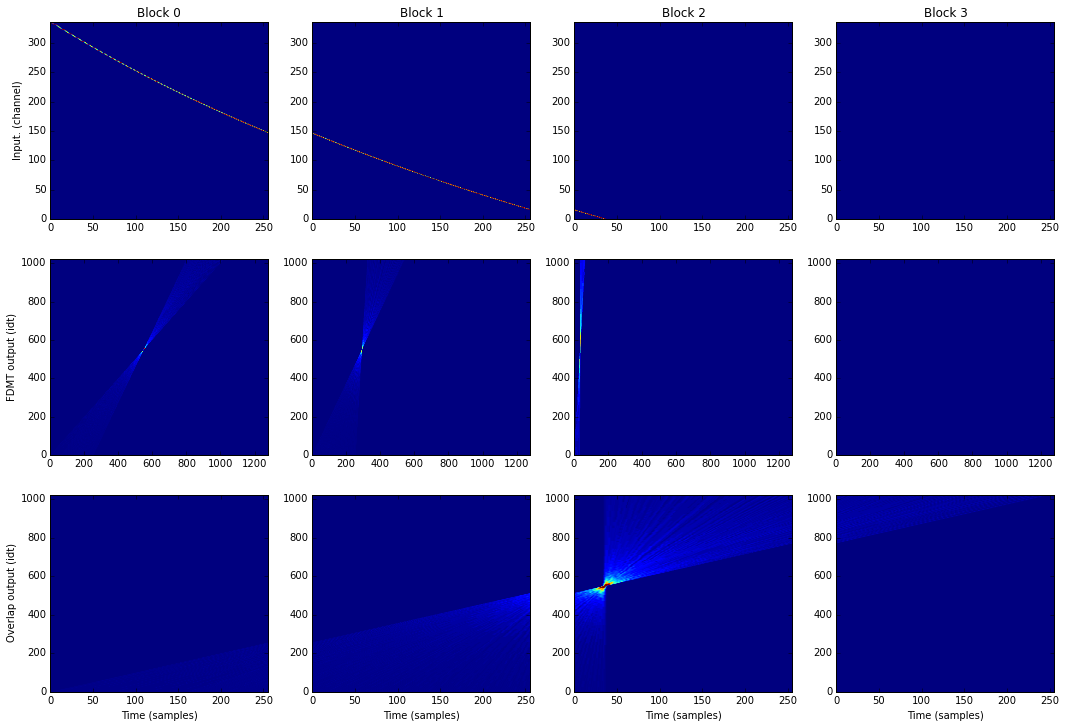

In [27]:
longfrb_out = plot_fdmt_osum(thefdmt, longfrb, osum_vmax=longfrb.sum()/6)
print longfrb_out.max(), longfrb.sum()

# Weighting

The raw FDMT output is just the sum of things. We want to work in units of S/N. So we FREDDA makes the input 0 noise and 1 standard deviation (across times, per channel, independantly) and then does the FDMT and weights afterwards.

FREDDA calculates the weights by pushing ones through the FDMT and overlap process and using that to calculate the weights. Here's the process

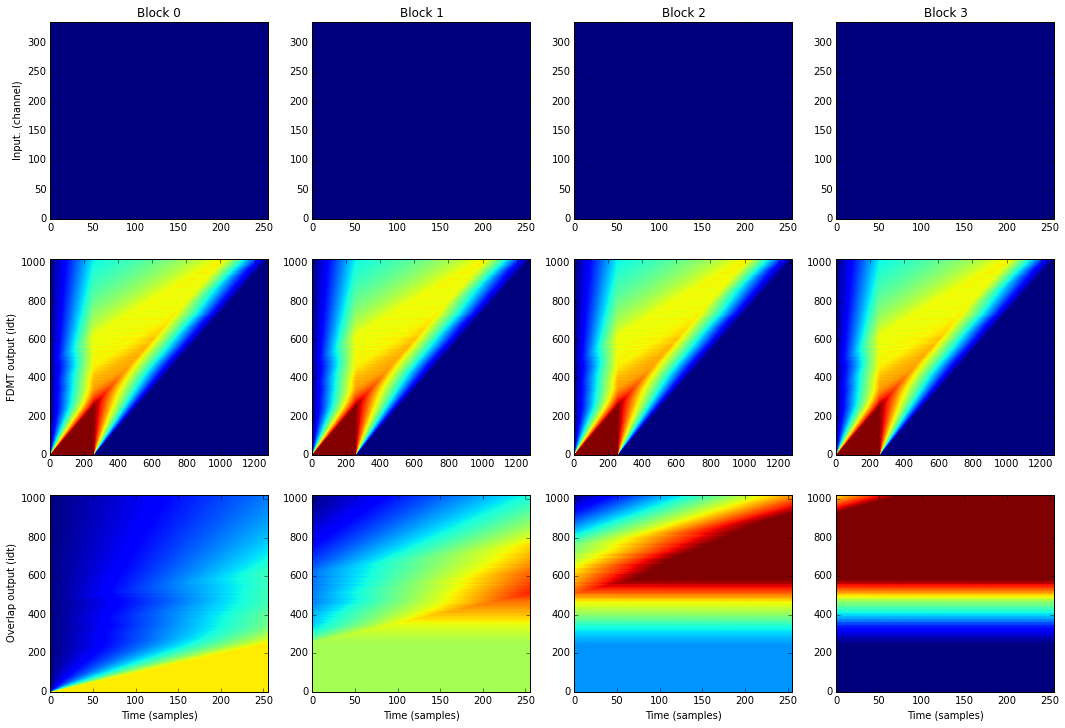

In [28]:
ones = np.ones((nf, nd), dtype=np.float32)
ones_output = plot_fdmt_osum(thefdmt, ones, osum_vmax=nd/2)

By the end of the final block we've filled the overlap and sum buffer and we have the weights. In practice FREDDA actually runs 5 blocks through and picks the first time sample out, but that's not relevant right now. 

From here we can work out the number of hits and the weights

(4, 1024, 256)


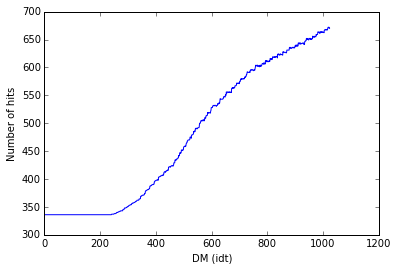

In [29]:
# number of hits is the output at the end of hte final block
print ones_output.shape
nhits = ones_output[-1, :, -1]
plot(nhits)
xlabel('DM (idt)')
ylabel('Number of hits')

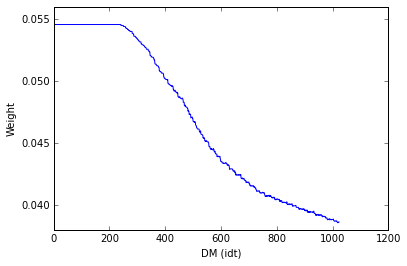

In [28]:
# And the weights are 1 /sqrt(nhits)
weights = 1./np.sqrt(nhits)
plot(weights)
xlabel('DM (idt)')
ylabel('Weight')

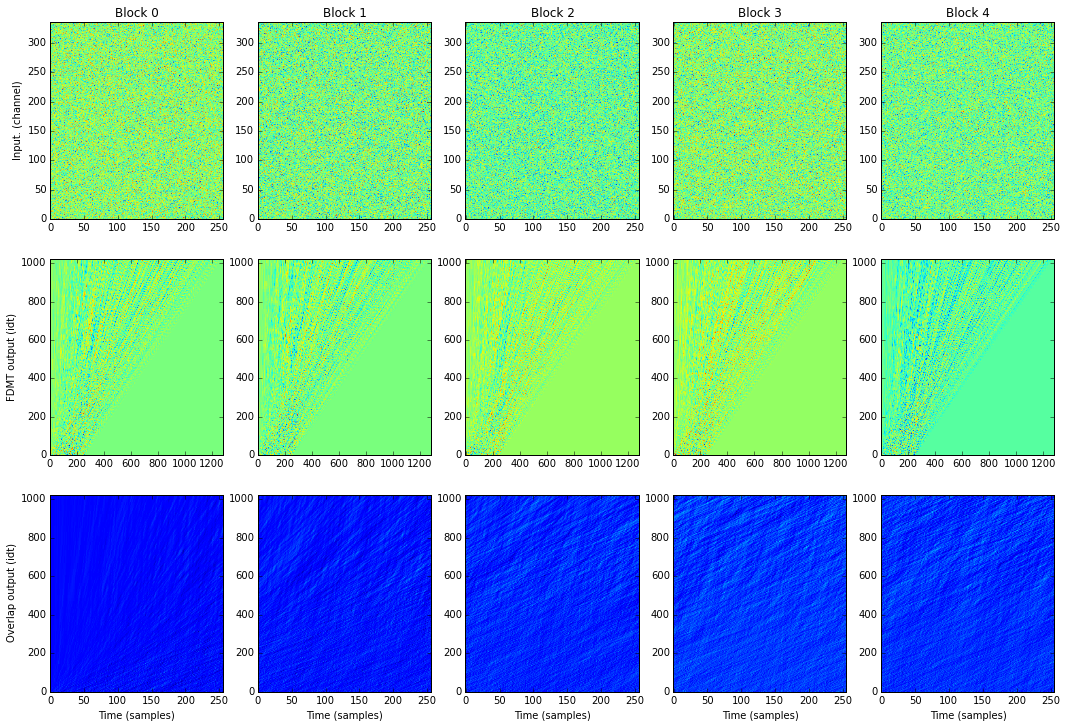

In [29]:
# OK now if we run noise through the FDMT
# This time we'll do an extra block so the final block has the full history noise in it
noise = np.random.randn(nf, nd + nt).astype(np.float32)
noise_output = plot_fdmt_osum(thefdmt, noise, osum_vmax=nd/2)


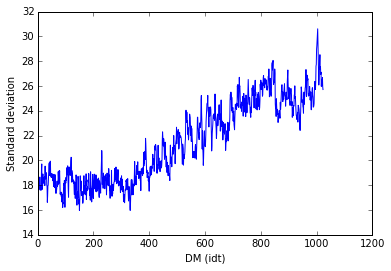

In [11]:
# Let's look at the standard deviation of the final block vs DM
plot(noise_output[-1, :, :].std(axis=1))
xlabel('DM (idt)')
ylabel('Standard deviation')

In [12]:
# Now we'll weight by the weights we calculated earlier
# Use the numpy broadcasting trick
print noise_output.shape
noise_output_weighted = noise_output*weights[np.newaxis, :, np.newaxis]

(5, 1024, 256)


Average standard deviation (should be close to 1) 0.9917107382069765


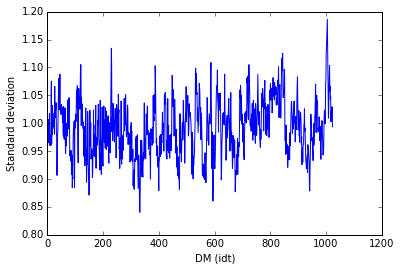

In [13]:
# Let's look at the standard deviation of the final block vs DM
plot(noise_output_weighted[-1, :, :].std(axis=1))
xlabel('DM (idt)')
ylabel('Standard deviation')
print 'Average standard deviation (should be close to 1)', noise_output_weighted[-1, :, :].std(axis=1).mean()

# Beautiful!

# The dificulty - box-caring

OK - let's review where we're up to. We've done our FDMT it's done some time averaging already. We've scaled the output so it's output has unit variance - it's an S/N. Yaaay.

Here's where the trouble starts.  

In [30]:
# create a boxcar - this has a history in it so it remembers the last few samples of a block
theboxcar = boxcar.Boxcar(nd, nbox=32, dtype=np.float32)

#push the block through the boxcar
bcout = np.array([theboxcar(noise_output_weighted[d, :, :].astype(np.float32)) \
                  for d in xrange(noise_output_weighted.shape[0])])

In [32]:
print bcout.shape

# boxcar weights are 1/sqrt(w+1) where w=0..nbox-1
bcweights = 1/np.sqrt(np.arange(32)+1)
bcout_weighted = bcout*bcweights[np.newaxis, np.newaxis, np.newaxis, :]

(5, 1024, 256, 32)


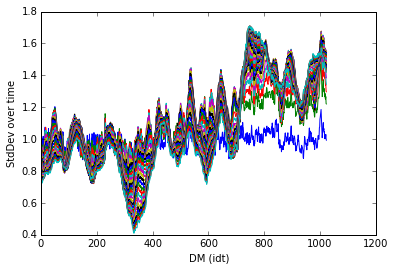

In [34]:
# Plot stddev over time vs DM and boxcar
bcstd = bcout_weighted[-1, :, :, :].std(axis=1)
_ = plot(bcstd)
xlabel('DM (idt)')
ylabel('StdDev over time')

# Oh, gee, now that's bad!

So there you what it. Boxcaring the FDMT makes a big fat mess. i don't like it, but I don't like not having my nifty feature either, because I like nifty features and askap has a tiny diagonal DM which means we need all the S/N we can get to get out to high DMs/redshifts.

So there.

# What I wantz

I want a way of calculating the weights w(dm, boxcar) which doesn't require simulation, as it's probably frequency dependant.
